### COVID-19 Tracking for Province of Ontario

These plots use data which has bee collected from the Ontario Ministry of Health and Long-Term Care's COVID-19 status page: https://www.ontario.ca/page/2019-novel-coronavirus

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = 'retina'

# Set large plotting parameters
plt.rcParams["figure.figsize"] = (20.0, 8.0)
plt.rcParams["figure.titlesize"] = 20
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["lines.markersize"] = 15
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["legend.fontsize"] = 16
plt.rcParams['axes.facecolor'] = 'white'

In [3]:
from datetime import datetime
todaystring = datetime.now().strftime("%Y-%m-%d")

### Data Manipulation

Read in the data saved in the `midas` directory. These are the same status updates from MOHLTC being saved by [MIDAS](https://github.com/midas-network/COVID-19/tree/master/data/cases/canada/ontario_situation_updates):

In [23]:
!ls ../midas/

Cases_in_Ontario_2020-02-11.csv Cases_in_Ontario_2020-03-05.csv
Cases_in_Ontario_2020-02-12.csv Cases_in_Ontario_2020-03-06.csv
Cases_in_Ontario_2020-02-13.csv Cases_in_Ontario_2020-03-07.csv
Cases_in_Ontario_2020-02-14.csv Cases_in_Ontario_2020-03-08.csv
Cases_in_Ontario_2020-02-15.csv Cases_in_Ontario_2020-03-09.csv
Cases_in_Ontario_2020-02-16.csv Cases_in_Ontario_2020-03-10.csv
Cases_in_Ontario_2020-02-17.csv Cases_in_Ontario_2020-03-11.csv
Cases_in_Ontario_2020-02-18.csv Cases_in_Ontario_2020-03-12.csv
Cases_in_Ontario_2020-02-19.csv Cases_in_Ontario_2020-03-13.csv
Cases_in_Ontario_2020-02-20.csv Cases_in_Ontario_2020-03-14.csv
Cases_in_Ontario_2020-02-21.csv Cases_in_Ontario_2020-03-15.csv
Cases_in_Ontario_2020-02-22.csv Cases_in_Ontario_2020-03-16.csv
Cases_in_Ontario_2020-02-23.csv Cases_in_Ontario_2020-03-17.csv
Cases_in_Ontario_2020-02-24.csv Cases_in_Ontario_2020-03-18.csv
Cases_in_Ontario_2020-02-25.csv Cases_in_Ontario_2020-03-19.csv
Cases_in_Ontario_2020-02-26.csv Cases_in

In [75]:
# Read in all the csvs from the directory, put into a list of dataframes and concatenate:
import glob

path = r'../midas/' # use your path
all_files = glob.glob(path + "/Cases*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

/Users/mylesharrison/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


In [76]:
# Convert the DataUpdated column to a datetime
frame['DataUpdated'] = pd.to_datetime(frame['DataUpdated'])

# Sort values in ascending chronological order and reset index
frame.sort_values(by='DataUpdated', inplace=True)
frame.reset_index(inplace=True)
frame.drop('index', axis=1, inplace=True)

frame.tail()

,Confirmed negative,Confirmed positive,Currently under investigation,DataUpdated,Deceased,Footnotes,Negative,Presumptive negative,Presumptive positive,Resolved,Total number of patients approved for 2019-nCoV testing to date,Total number of patients approved for COVID-19 testing to date
40,NaN,368,7239,2020-03-21 17:30:00-04:00,3.0,Negative: Patient negative based on testing pe...,15768.0,NaN,NaN,6.0,NaN,23384.0
41,NaN,412,8361,2020-03-22 17:30:00-04:00,5.0,Negative: Patient negative based on testing pe...,17634.0,NaN,NaN,8.0,NaN,26420.0
42,NaN,489,8417,2020-03-23 17:30:00-04:00,6.0,Negative: Patient negative based on testing pe...,19586.0,NaN,NaN,8.0,NaN,28506.0
43,NaN,572,10074,2020-03-24 17:30:00-04:00,8.0,Negative: Patient negative based on testing pe...,21795.0,NaN,NaN,8.0,NaN,32457.0
44,NaN,667,10489,2020-03-25 17:30:00-04:00,13.0,Negative: Patient negative based on testing pe...,24458.0,NaN,NaN,8.0,NaN,35635.0


In [77]:
# Combine the columns for presumed +ve/-ve and confirmed +ve/-ve due to schema change
frame['presumed_or_confirmed_positive'] = frame['Presumptive positive'].fillna(0) + \
                                          frame['Confirmed positive'].fillna(0)

frame['presumed_or_confirmed_negative'] = frame['Presumptive negative'].fillna(0) + \
                                          frame['Confirmed negative'].fillna(0) + frame['Negative'].fillna(0)

# Combine columns for total approved for testing
frame['total_approved_for_testing'] = \
    frame['Total number of patients approved for 2019-nCoV testing to date'].fillna(0) + \
    frame['Total number of patients approved for COVID-19 testing to date'].fillna(0)

# Calculate column for total tested (-ve + +ve + deceased + resolved)
frame['total_tested'] = frame['presumed_or_confirmed_positive'] + \
                        frame['presumed_or_confirmed_negative'] + \
                        frame['Deceased'].fillna(0) + \
                        frame['Resolved'].fillna(0)

In [78]:
# Check the math: Total approved for testing = total tested + currently under investigation
assert (frame['total_tested'] + frame['Currently under investigation'] == frame['total_approved_for_testing']).all()

In [79]:
# Reorder columns: DataUpdated, original columns (with nans), then calculated columns
frame = frame[['DataUpdated', 'Presumptive negative','Confirmed negative','Presumptive positive',\
       'Confirmed positive','Resolved','Deceased','Currently under investigation', \
        'Total number of patients approved for 2019-nCoV testing to date', \
        'Total number of patients approved for COVID-19 testing to date', \
      'presumed_or_confirmed_positive', 'presumed_or_confirmed_negative', 'total_approved_for_testing', 'total_tested']]

In [80]:
# Write output
frame.to_csv('../csv/case_statuses_'+todaystring+'.csv')

### Visualization

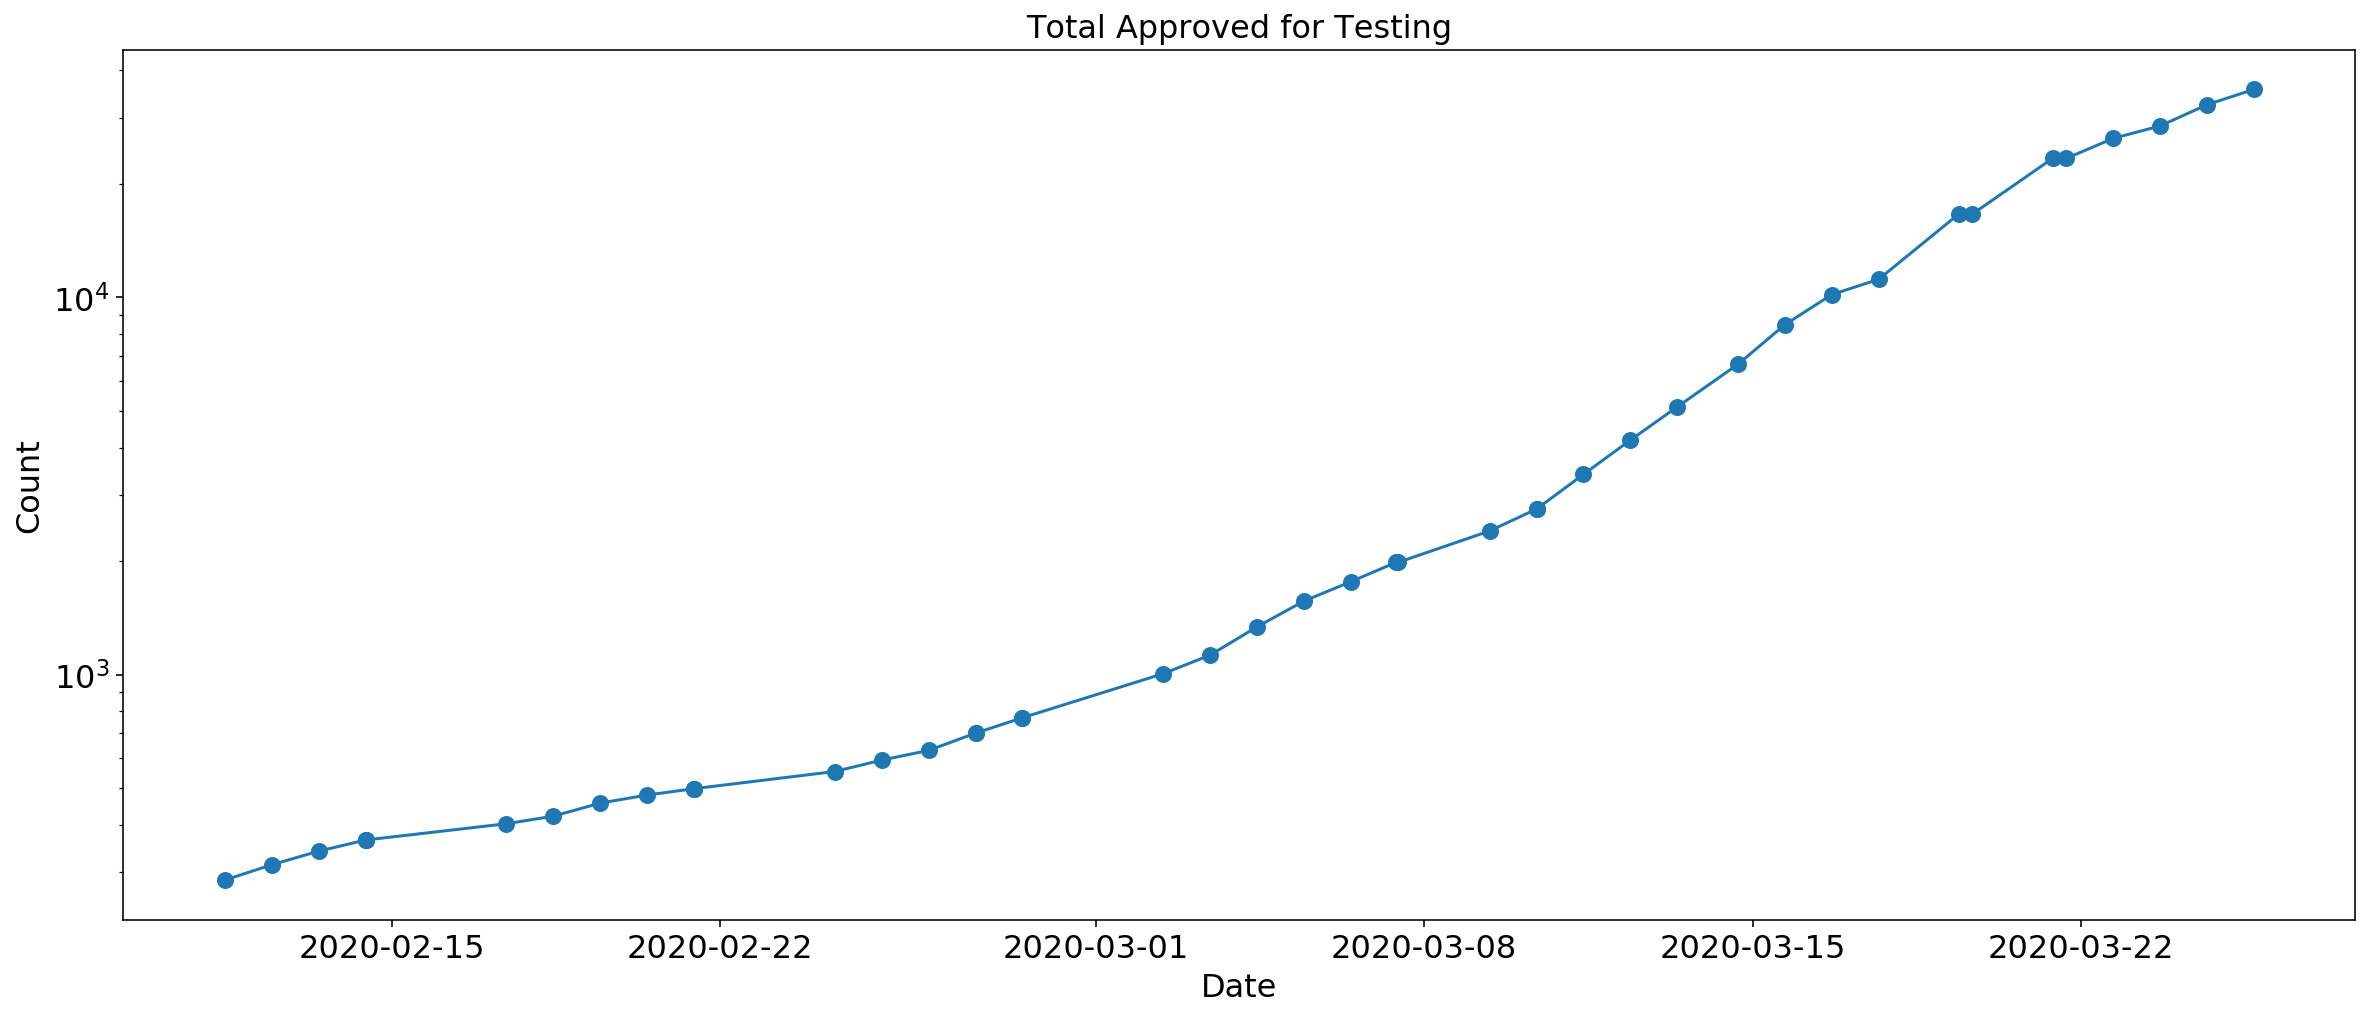

In [81]:
# Total approved for testing
plt.figure
plt.plot(frame['DataUpdated'], frame['total_approved_for_testing'], marker='.')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Total Approved for Testing')
plt.yscale('log')

In [85]:
frame

,DataUpdated,Presumptive negative,Confirmed negative,Presumptive positive,Confirmed positive,Resolved,Deceased,Currently under investigation,Total number of patients approved for 2019-nCoV testing to date,Total number of patients approved for COVID-19 testing to date,presumed_or_confirmed_positive,presumed_or_confirmed_negative,total_approved_for_testing,total_tested
0,2020-02-11 10:30:00-05:00,79.0,184.0,0.0,3,NaN,NaN,19,285.0,NaN,3.0,263.0,285.0,266.0
1,2020-02-12 10:30:00-05:00,44.0,257.0,0.0,2,1.0,NaN,9,313.0,NaN,2.0,301.0,313.0,304.0
2,2020-02-13 10:30:00-05:00,16.0,306.0,0.0,2,1.0,NaN,15,NaN,340.0,2.0,322.0,340.0,325.0
3,2020-02-14 10:30:00-05:00,0.0,353.0,0.0,2,1.0,NaN,8,NaN,364.0,2.0,353.0,364.0,356.0
4,2020-02-14 10:30:00-05:00,0.0,353.0,0.0,2,1.0,NaN,8,NaN,364.0,2.0,353.0,364.0,356.0
5,2020-02-14 10:30:00-05:00,0.0,353.0,0.0,2,1.0,NaN,8,NaN,364.0,2.0,353.0,364.0,356.0
6,2020-02-17 10:30:00-05:00,0.0,399.0,0.0,2,1.0,NaN,0,NaN,402.0,2.0,399.0,402.0,402.0
7,2020-02-18 10:30:00-05:00,0.0,418.0,0.0,2,1.0,NaN,0,NaN,421.0,2.0,418.0,421.0,421.0
8,2020-02-19 10:30:00-05:00,0.0,436.0,0.0,2,1.0,NaN,17,NaN,456.0,2.0,436.0,456.0,439.0
9,2020-02-20 10:30:00-05:00,NaN,NaN,0.0,1,2.0,NaN,14,NaN,479.0,1.0,462.0,479.0,465.0


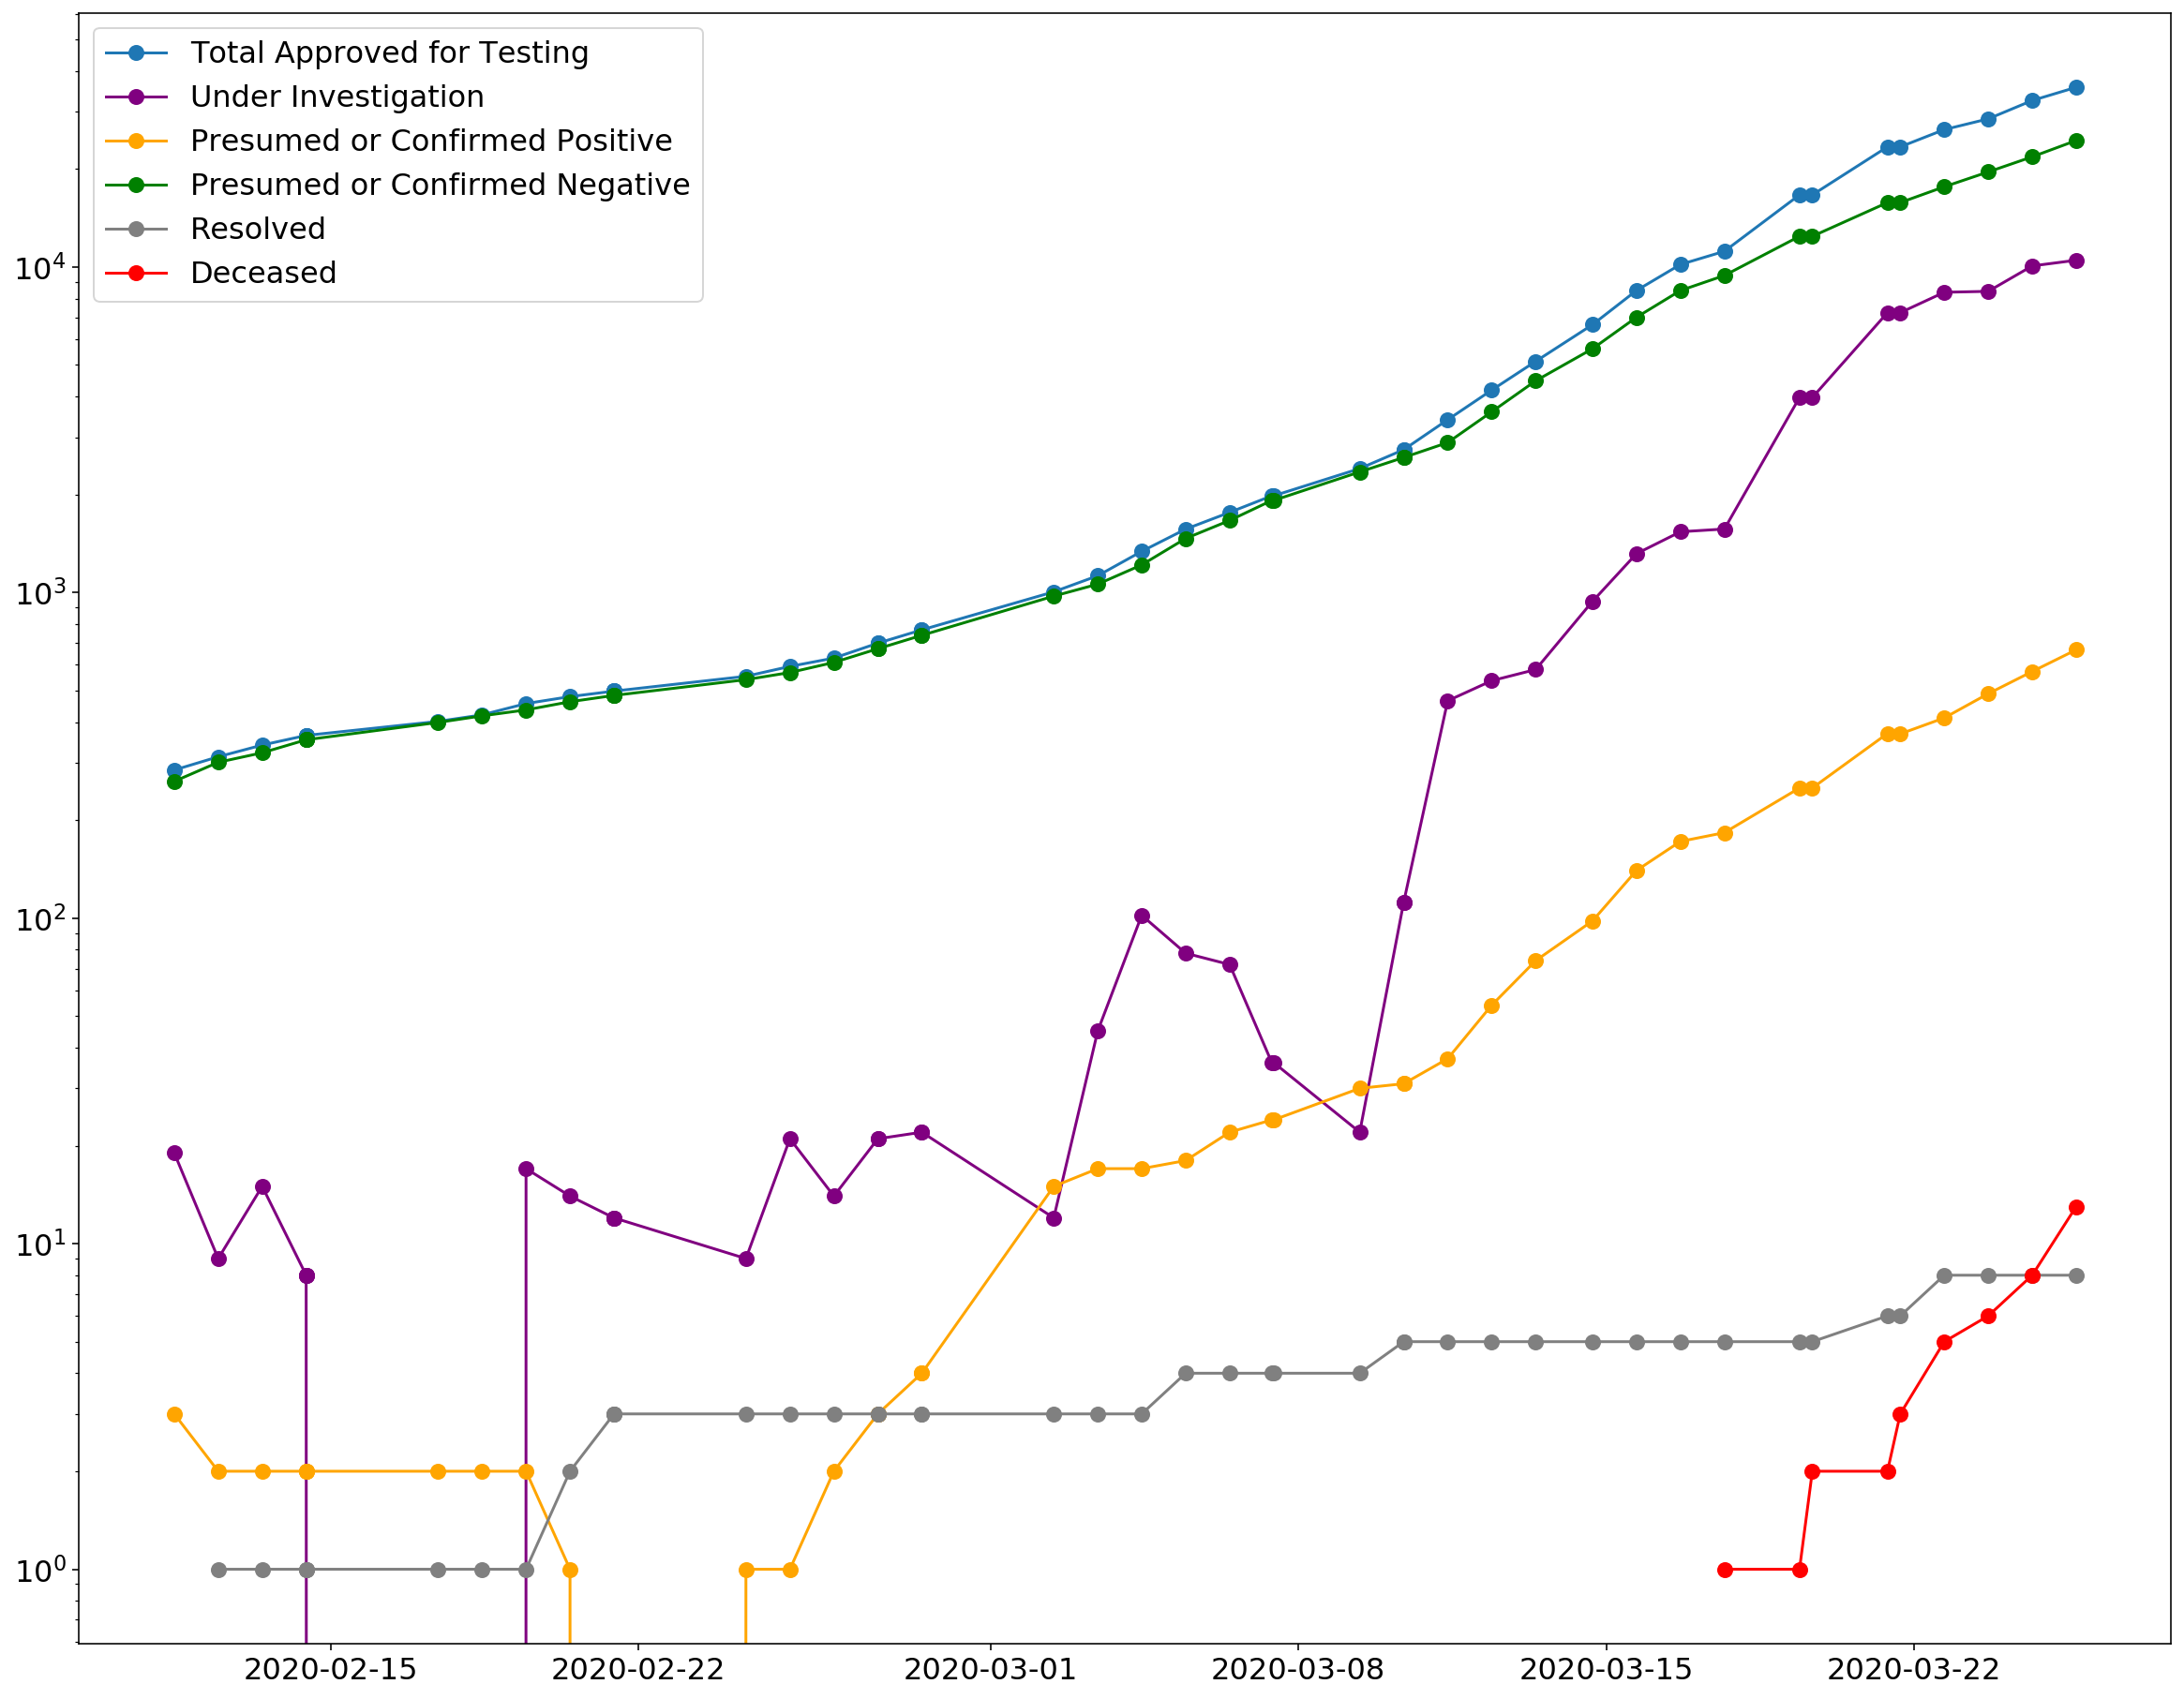

In [84]:
# Combined plot
fig = plt.figure(figsize=(20, 16))
plt.plot(frame['DataUpdated'], frame['total_approved_for_testing'], label='Total Approved for Testing', marker='.')
plt.plot(frame['DataUpdated'], frame['Currently under investigation'], label='Under Investigation', color='purple', marker='.')
plt.plot(frame['DataUpdated'], frame['presumed_or_confirmed_positive'], label='Presumed or Confirmed Positive', color='orange', marker='.')
plt.plot(frame['DataUpdated'], frame['presumed_or_confirmed_negative'], label='Presumed or Confirmed Negative', color='green', marker='.')
plt.plot(frame['DataUpdated'], frame['Resolved'], label='Resolved', color='gray', marker='.')
plt.plot(frame['DataUpdated'], frame['Deceased'], label='Deceased', color='red', marker='.')
plt.legend()
plt.yscale('log')
plt.show()
fig.savefig('../plots/summaryplot_' + todaystring + '.png')

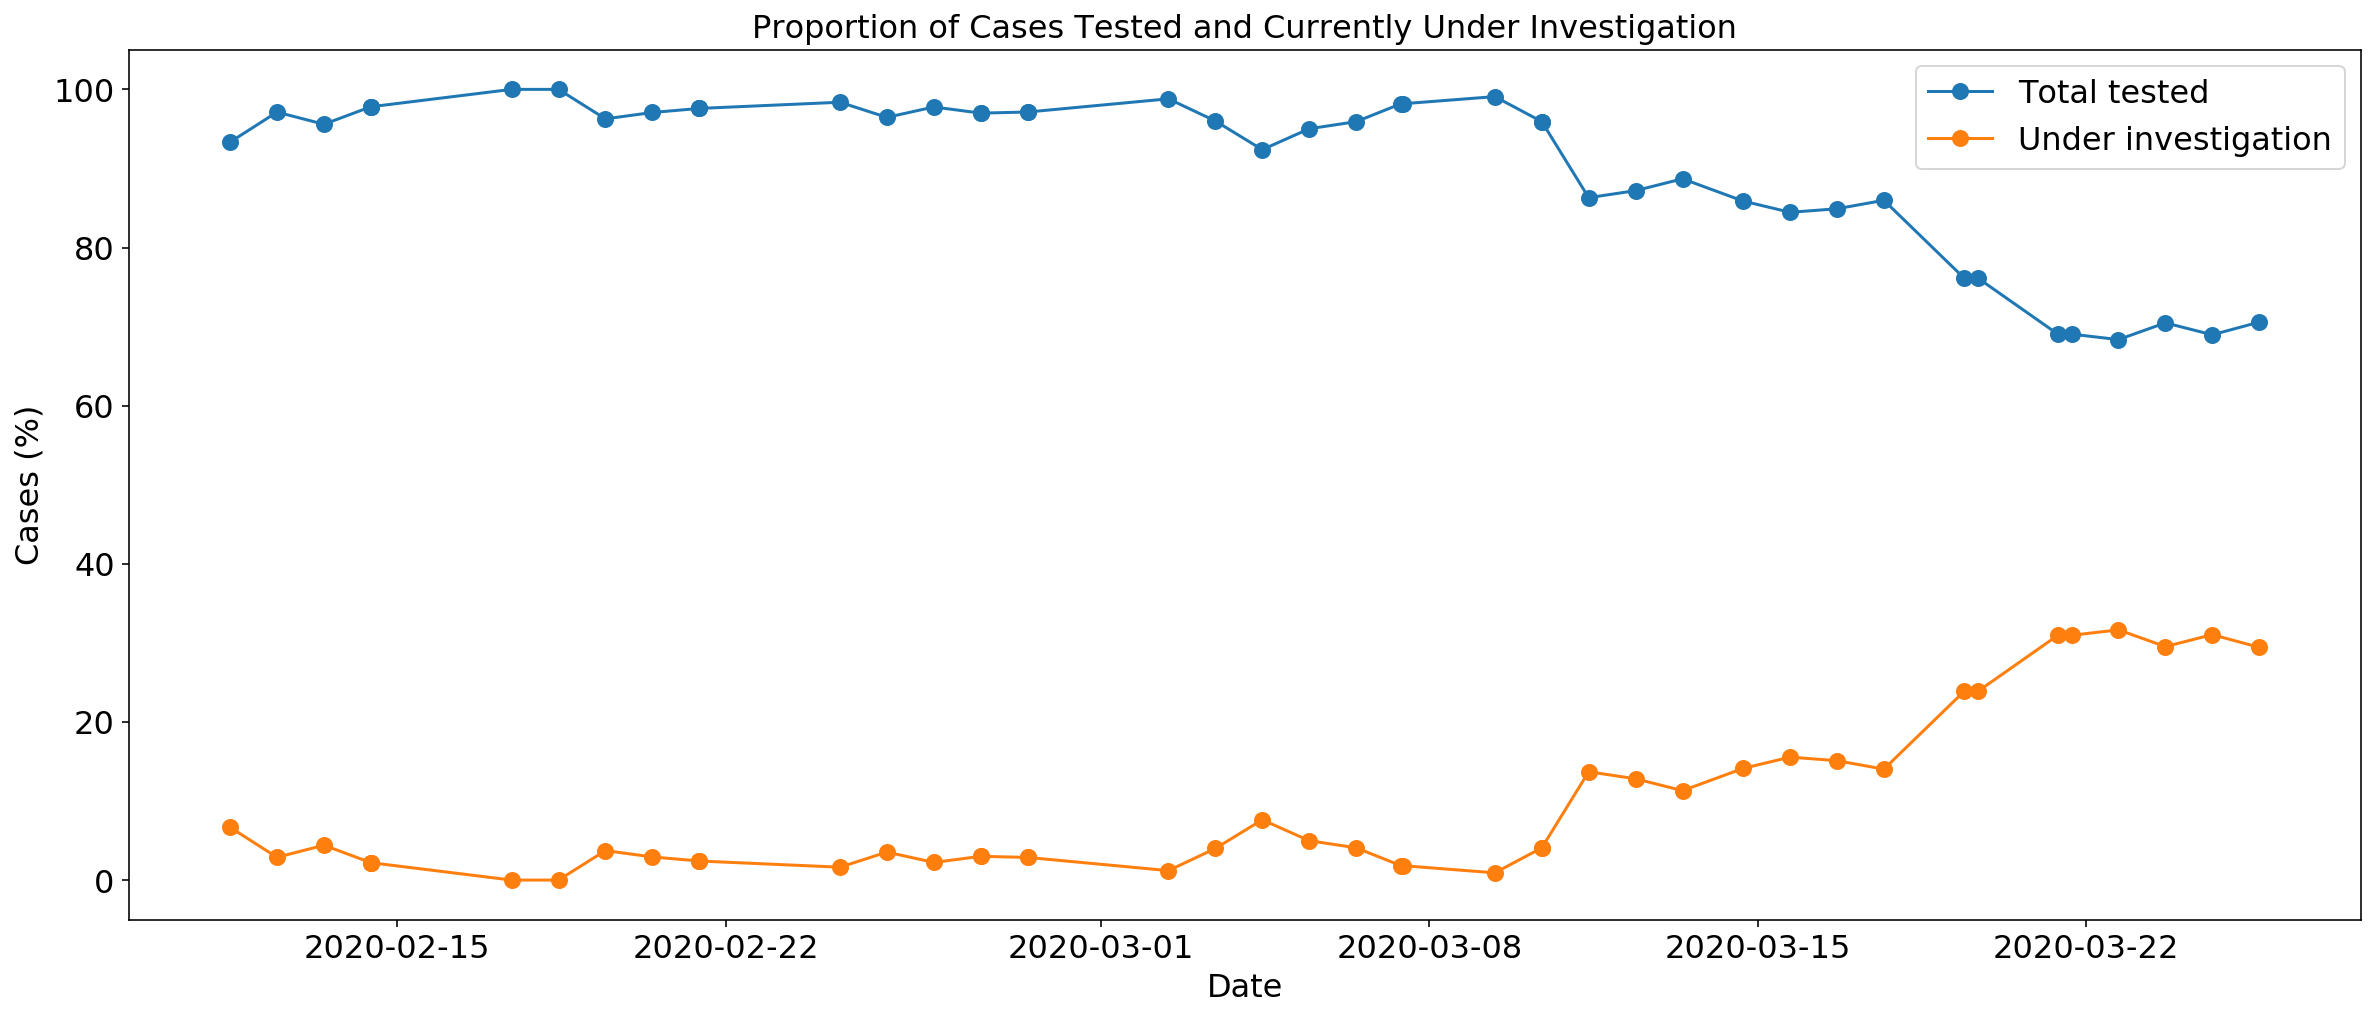

In [92]:
# Proportion tested vs. under investigation
plt.figure()
plt.plot(frame['DataUpdated'], frame['total_tested']/frame['total_approved_for_testing']*100.0, marker='.', label='Total tested')
plt.plot(frame['DataUpdated'], frame['Currently under investigation']/frame['total_approved_for_testing']*100.0, marker='.', label='Under investigation')
plt.xlabel('Date')
plt.ylabel('Cases (%)')
plt.title('Proportion of Cases Tested and Currently Under Investigation')
plt.legend()
plt.show()

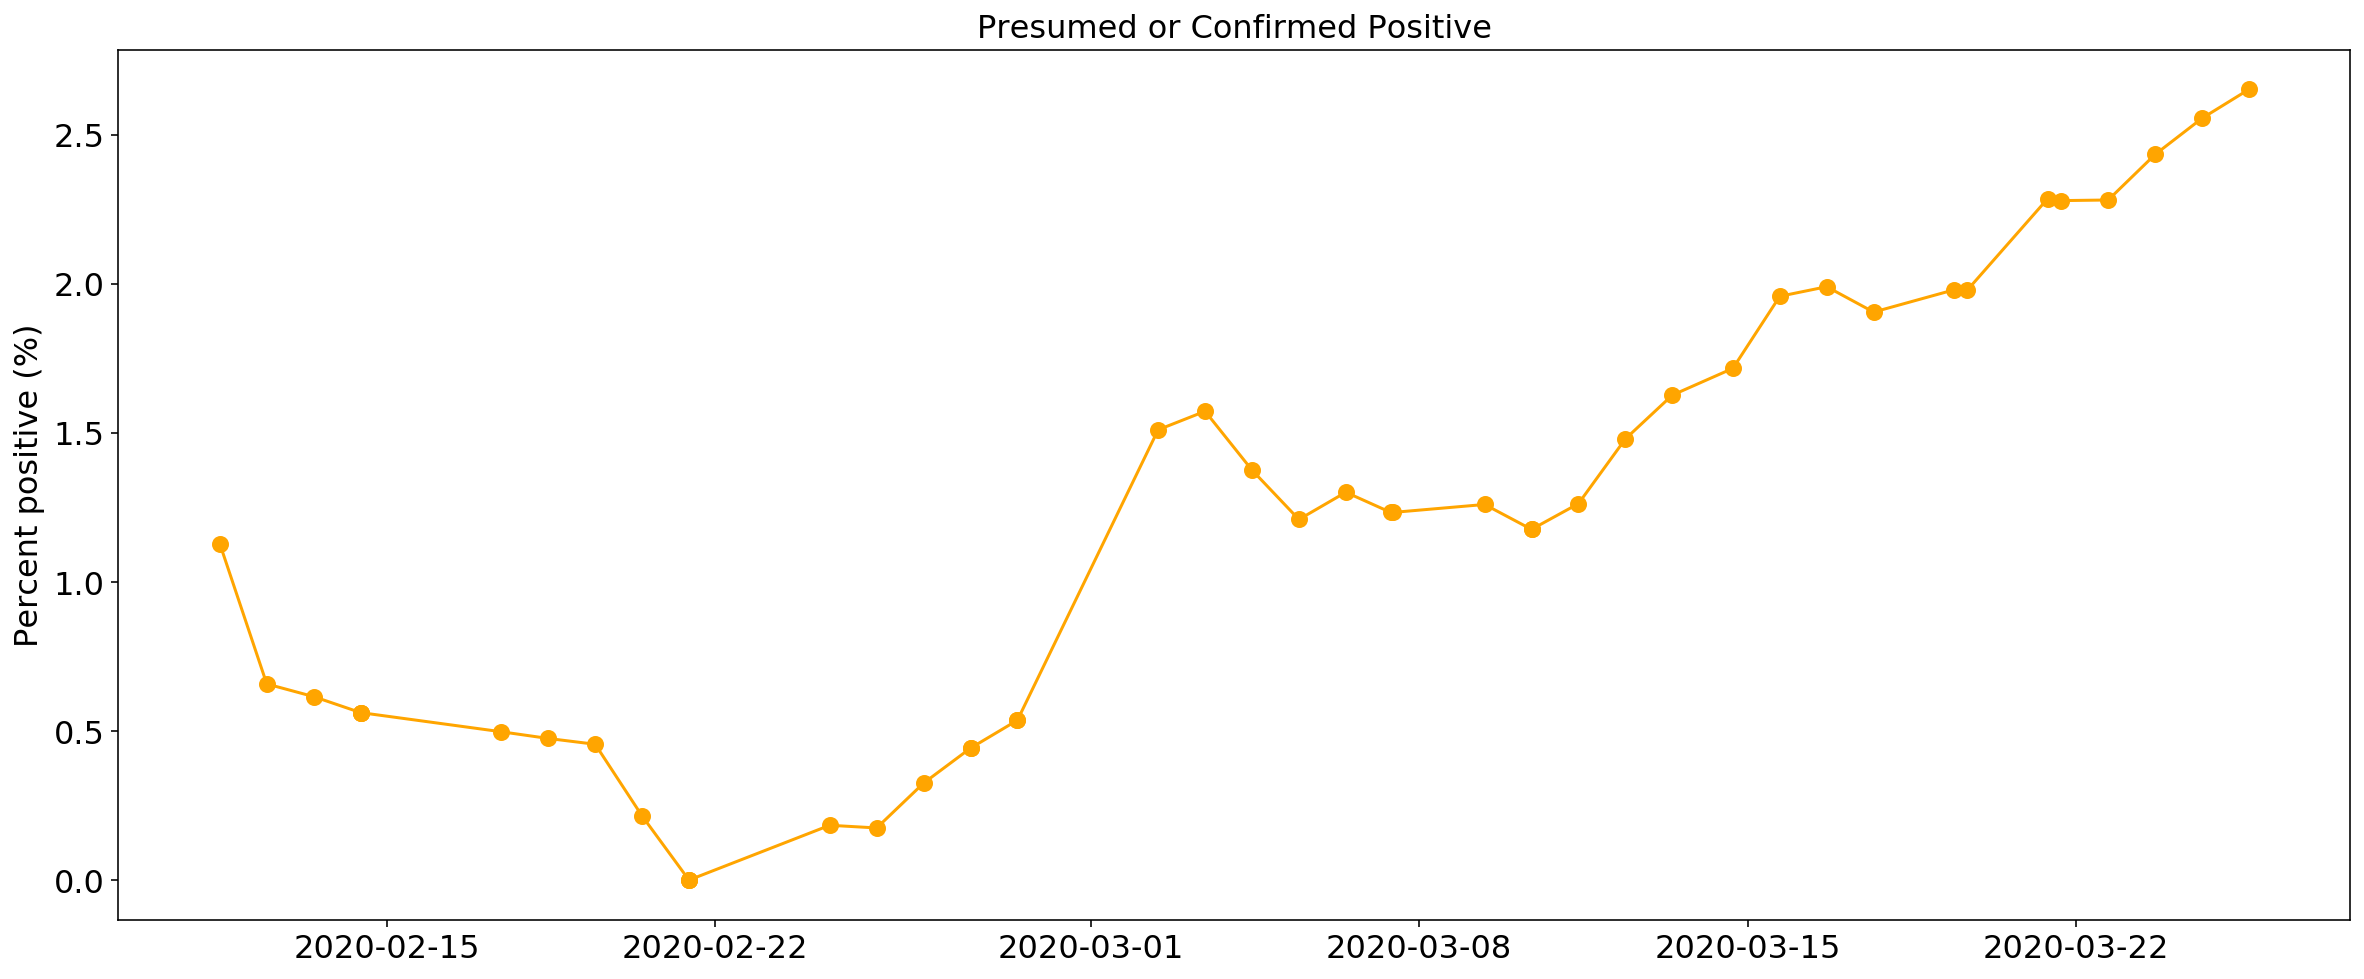

In [93]:
# Positive
positive_fig = plt.figure()
plt.plot(frame['DataUpdated'], frame['presumed_or_confirmed_positive']/frame['total_tested']*100.0, marker='.', color='orange')
plt.ylabel('Percent positive (%)')
plt.title('Presumed or Confirmed Positive')
plt.show()

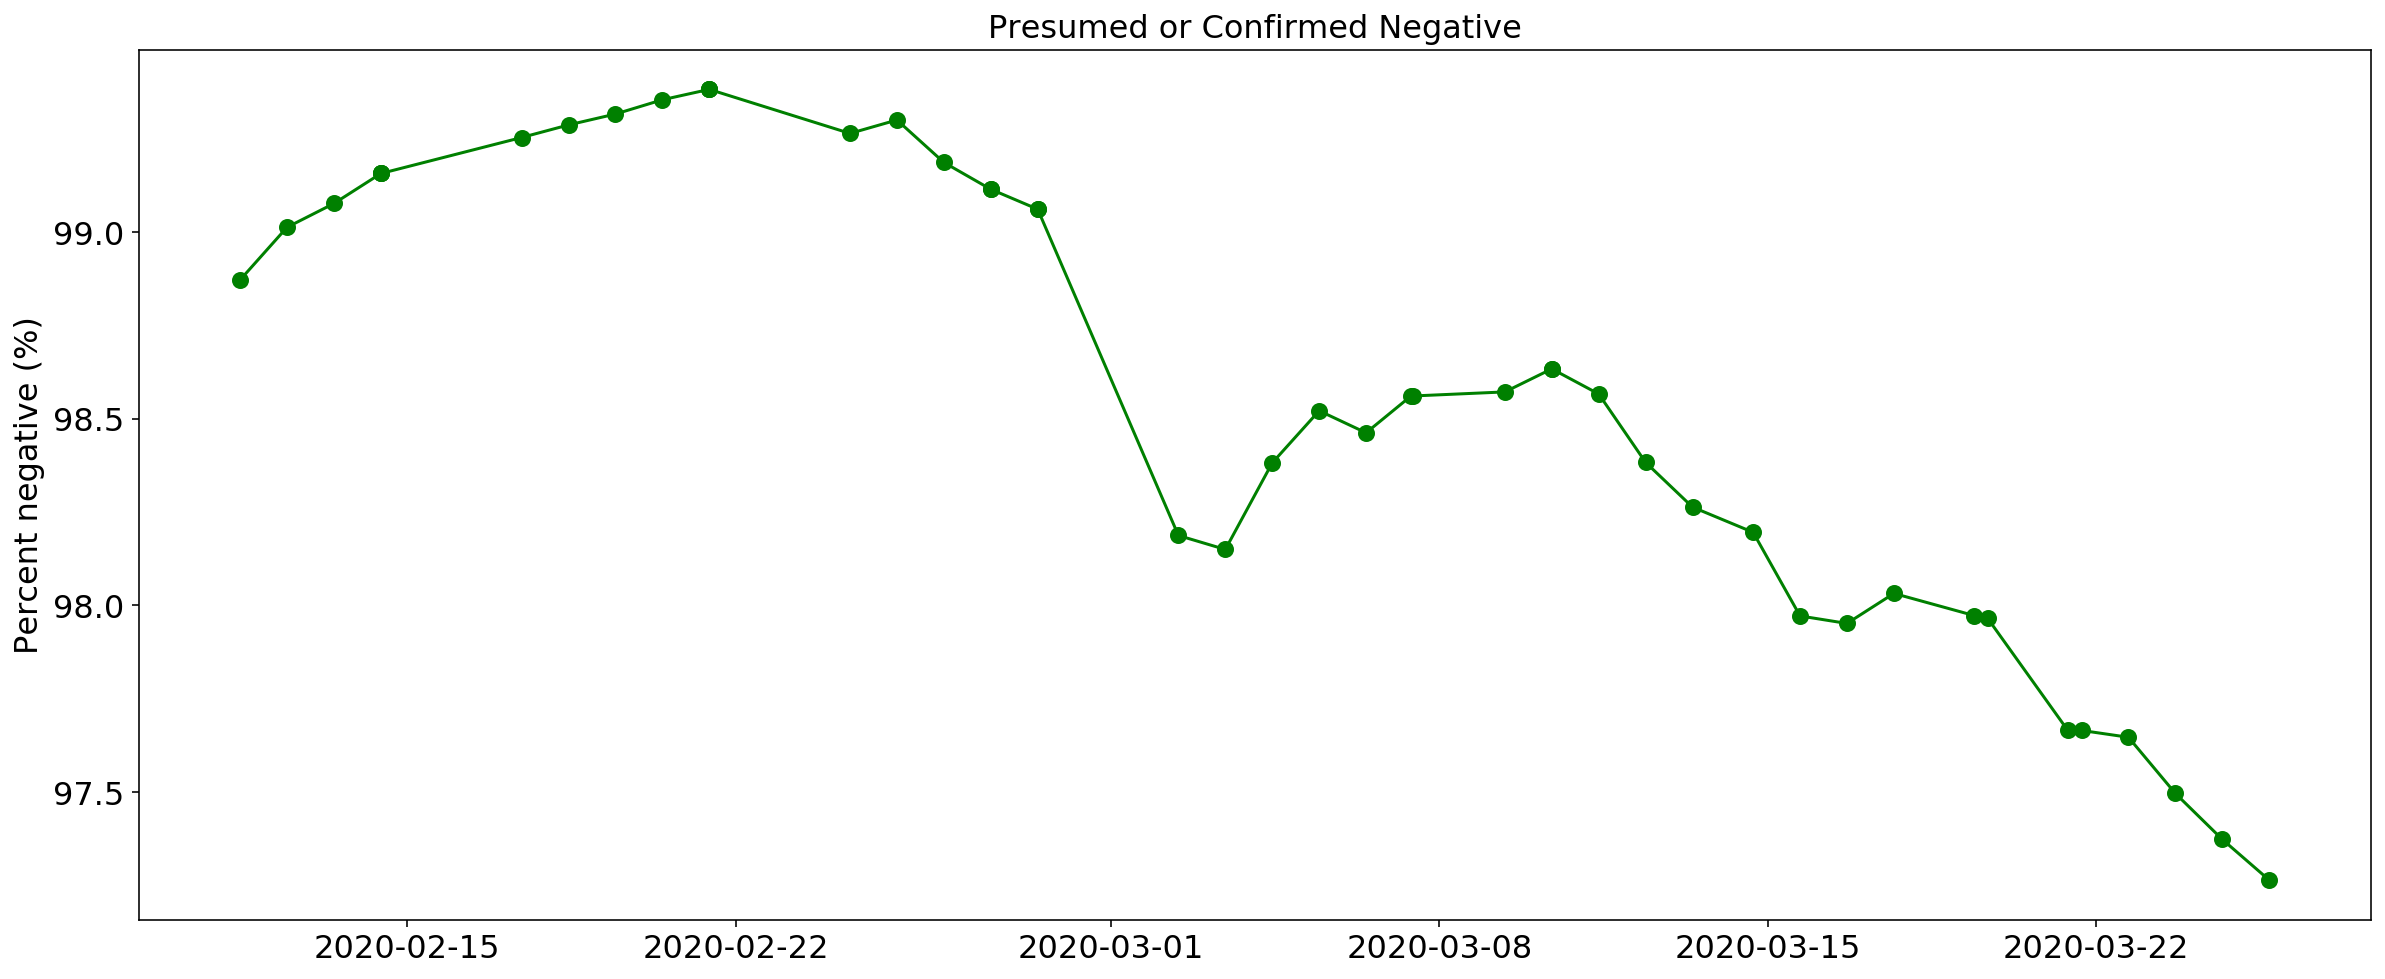

In [94]:
# Positive
negative_fig = plt.figure()
plt.plot(frame['DataUpdated'], frame['presumed_or_confirmed_negative']/frame['total_tested']*100.0, marker='.', color='green')
plt.ylabel('Percent negative (%)')
plt.title('Presumed or Confirmed Negative')
plt.show()

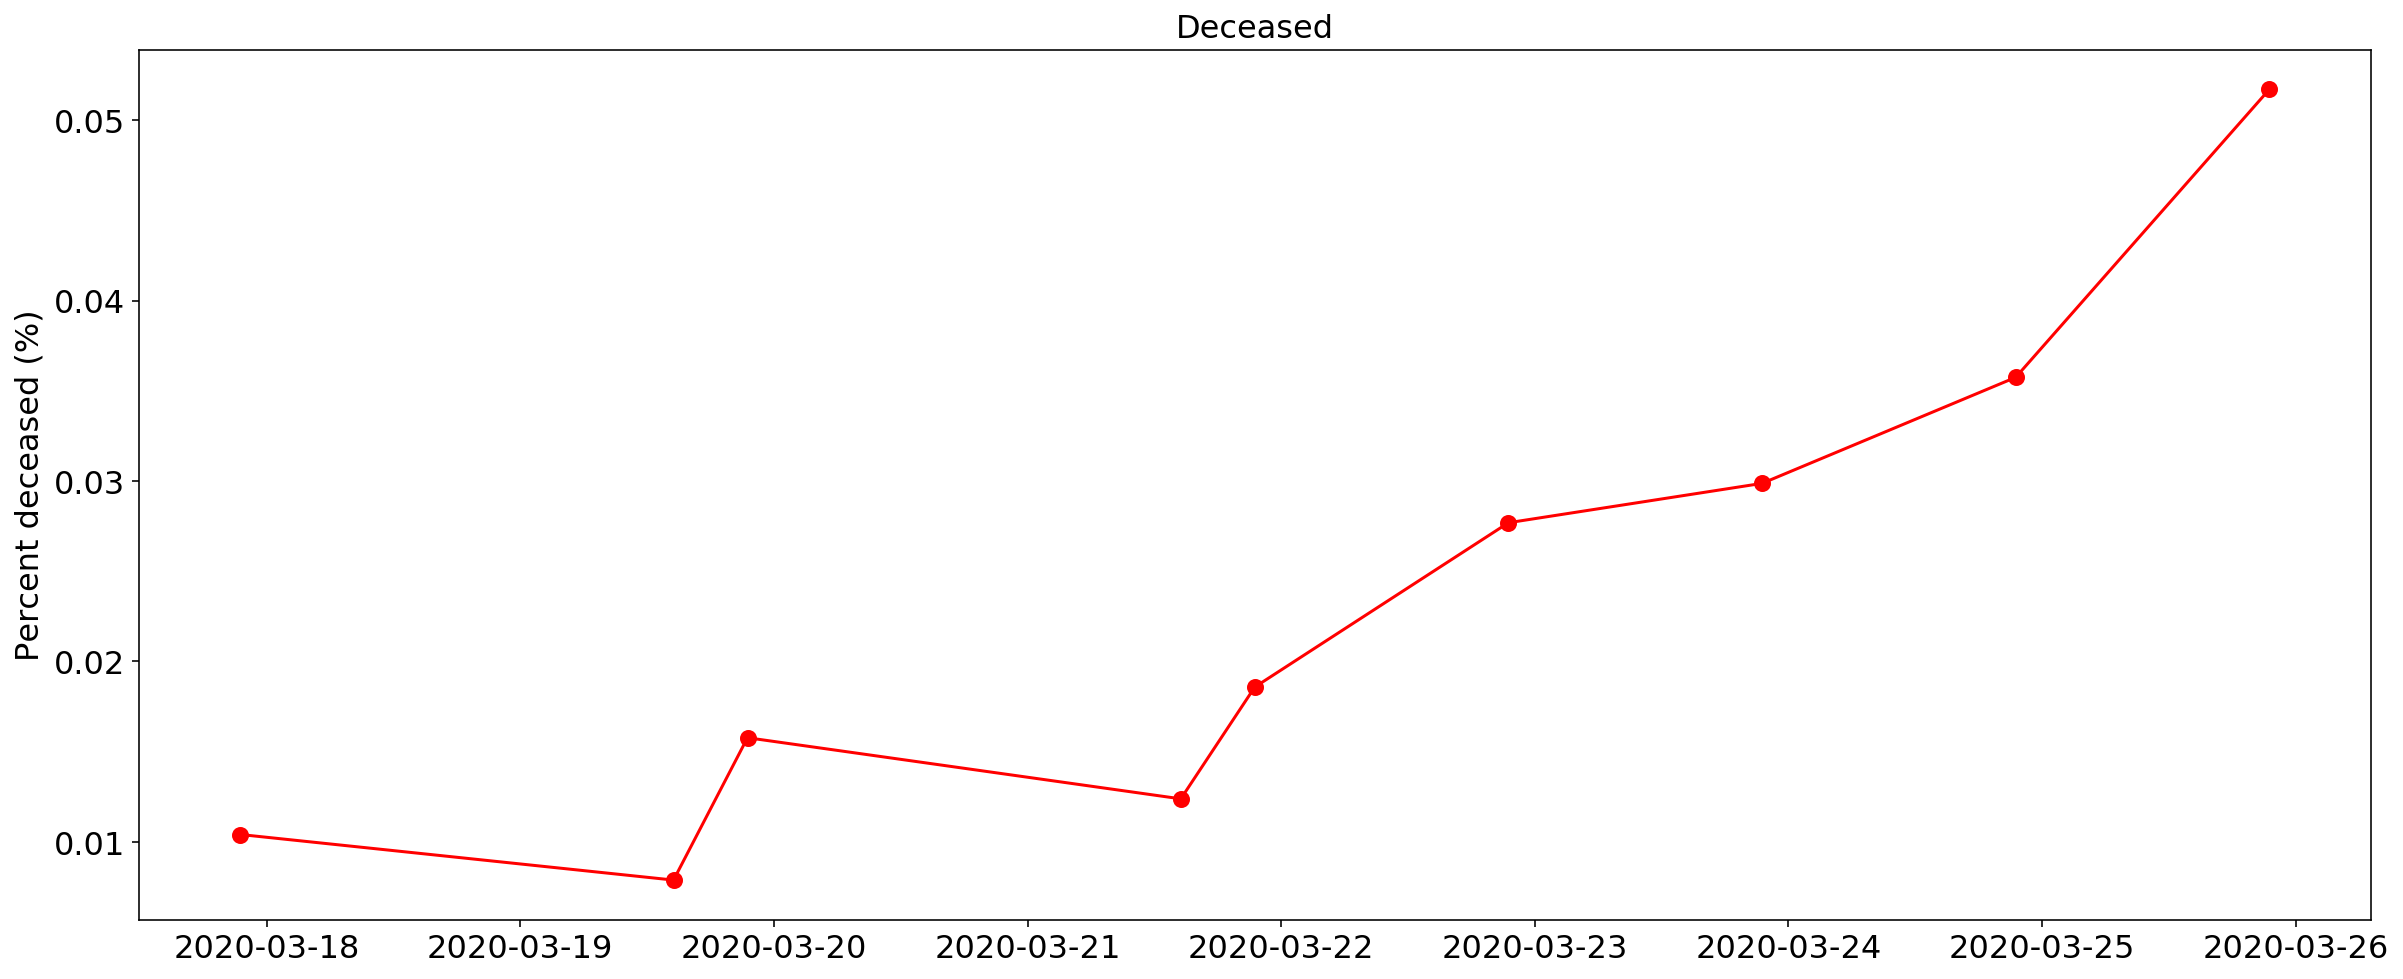

In [19]:
# Deceased
deceased_fig = plt.figure(figsize=(20, 8))
plt.plot(frame['DataUpdated'], frame['Deceased']/frame['total_tested']*100.0, marker='.', color='red')
plt.ylabel('Percent deceased (%)')
plt.title('Deceased')
plt.show()
#deceased_fig.savefig('../plots/deceasedplot_' + todaystring + '.png')

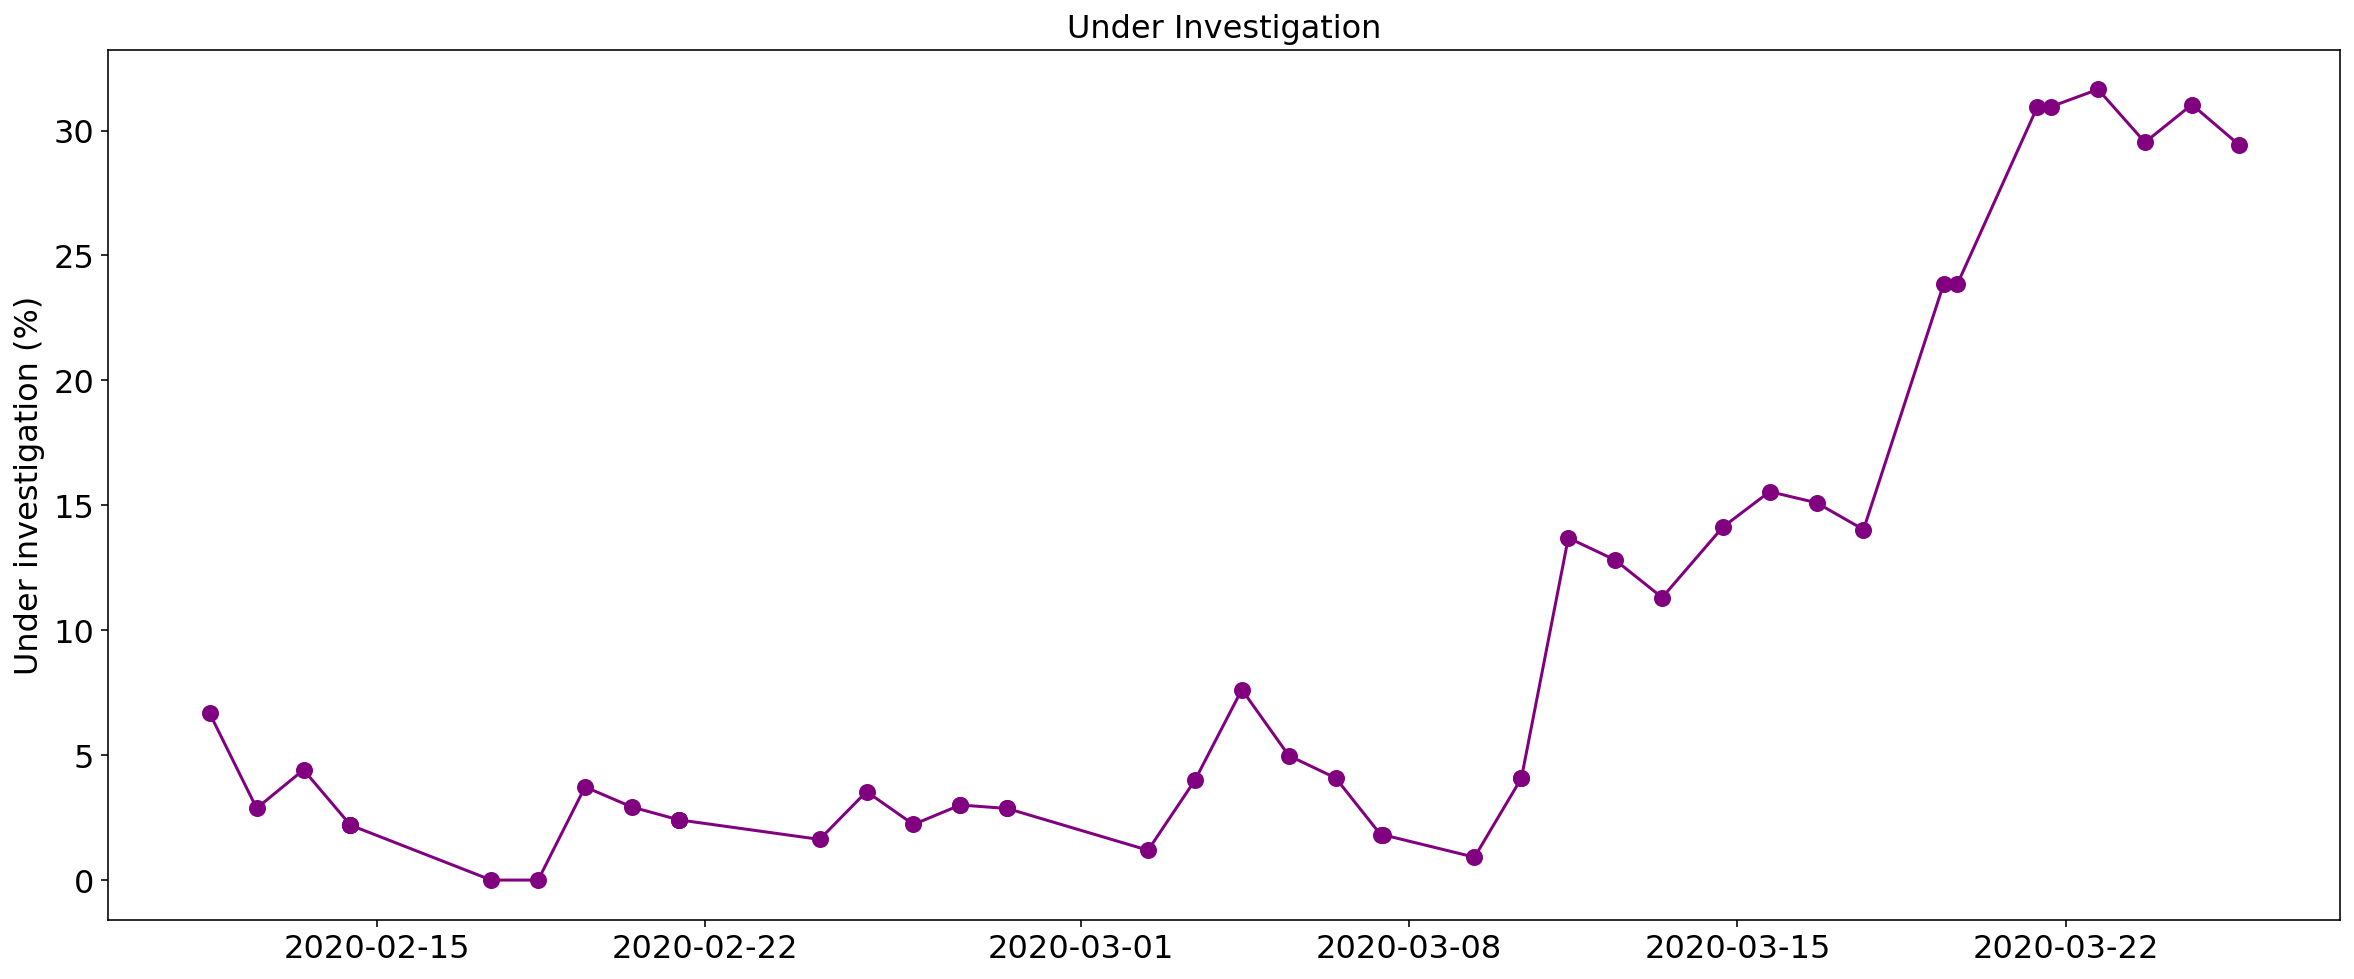

In [95]:
# Under investigation
investigation_fig = plt.figure()
plt.title('Under Investigation')
plt.plot(frame['DataUpdated'], frame['Currently under investigation']/frame['total_approved_for_testing']*100.0, marker='.', color='purple')
plt.ylabel('Under investigation (%)')
plt.show()
#investigation_fig.savefig('../plots/investigationplot_' + todaystring + '.png')

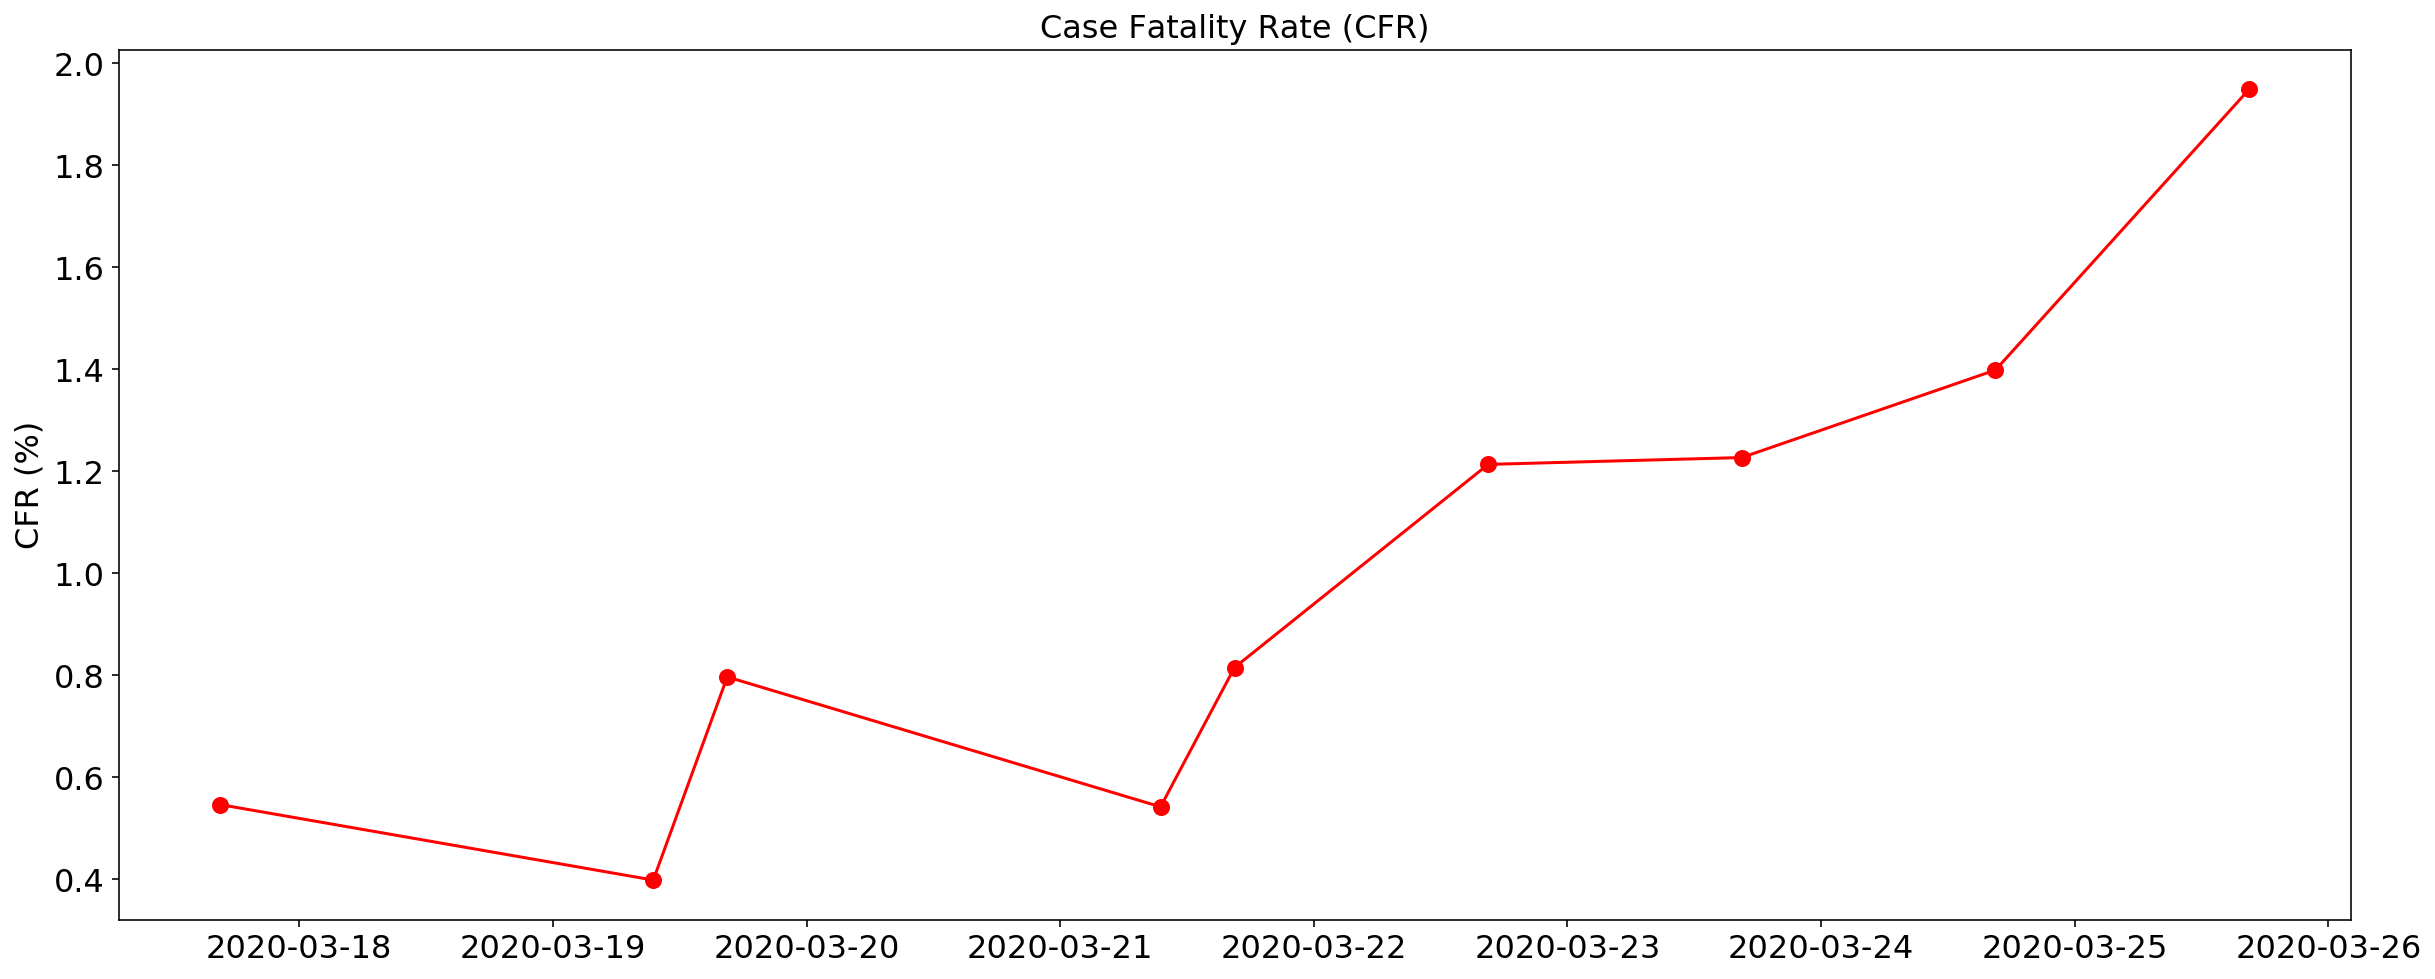

In [96]:
# Case Fatality Rate 
cfr_fig = plt.figure()
plt.title('Case Fatality Rate (CFR)')
plt.plot(frame['DataUpdated'], frame['Deceased']/frame['presumed_or_confirmed_positive']*100.0, marker='.',color='red')
plt.ylabel('CFR (%)')
plt.show()
#cfr_fig.savefig('../plots/cfrplot_' + todaystring + '.png')